In [1]:
# Importing libraries
import numpy as np
import tensorflow_datasets as tfds
import tensorflow as tf
import matplotlib.pyplot as plt

tfds.disable_progress_bar()

In [2]:
# Helper function for plotting 
def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])

In [3]:
dataset, info = tfds.load('imdb_reviews', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

train_dataset.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(), dtype=tf.int64, name=None))

In [4]:
# for example, label in train_dataset.take(1):
#   print('text: ', example.numpy())
#   print('label: ', label.numpy())

In [5]:
BUFFER_SIZE = 10000
BATCH_SIZE = 64

In [6]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE).batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)
test_dataset = test_dataset.batch(BATCH_SIZE).prefetch(tf.data.experimental.AUTOTUNE)

## Text Encoder

In [7]:
VOCAB_SIZE=1000
encoder = tf.keras.layers.experimental.preprocessing.TextVectorization(
    max_tokens=VOCAB_SIZE)
encoder.adapt(train_dataset.map(lambda text, label: text))

In [8]:
# vocab = np.array(encoder.get_vocabulary())
# vocab[:20]

In [9]:
# encoded_example = encoder(example)[:3].numpy()
# encoded_example


In [10]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=64,
        # Use masking to handle the variable sequence lengths
        mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

In [11]:
# print([layer.supports_masking for layer in model.layers])

In [12]:
# test_loss, test_acc = model.evaluate(test_dataset)

# print('Test Loss: {}'.format(test_loss))
# print('Test Accuracy: {}'.format(test_acc))

In [13]:
# plt.figure(figsize=(16,8))
# plt.subplot(1,2,1)
# plot_graphs(history, 'accuracy')
# plt.ylim(None,1)
# plt.subplot(1,2,2)
# plot_graphs(history, 'loss')
# plt.ylim(0,None)

In [14]:
# sample_text = ('The movie was cool. The animation and the graphics '
#                'were out of this world. I would recommend this movie.')
# predictions = model.predict(np.array([sample_text]))

In [15]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(len(encoder.get_vocabulary()), 64, mask_zero=True),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [16]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [17]:
checkpoint_path = "../models/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)


history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30,
                    callbacks=[cp_callback])

Epoch 1/10
391/391 [==============================] - ETA: 0s - loss: 0.6375 - accuracy: 0.5745
Epoch 00001: saving model to ../models/cp.ckpt
391/391 [==============================] - 335s 858ms/step - loss: 0.6375 - accuracy: 0.5745 - val_loss: 0.4400 - val_accuracy: 0.8130
Epoch 2/10
391/391 [==============================] - ETA: 0s - loss: 0.3858 - accuracy: 0.8320
Epoch 00002: saving model to ../models/cp.ckpt
391/391 [==============================] - 344s 879ms/step - loss: 0.3858 - accuracy: 0.8320 - val_loss: 0.3583 - val_accuracy: 0.8443
Epoch 3/10
391/391 [==============================] - ETA: 0s - loss: 0.3412 - accuracy: 0.8542
Epoch 00003: saving model to ../models/cp.ckpt
391/391 [==============================] - 338s 865ms/step - loss: 0.3412 - accuracy: 0.8542 - val_loss: 0.3347 - val_accuracy: 0.8458
Epoch 4/10
391/391 [==============================] - ETA: 0s - loss: 0.3211 - accuracy: 0.8637
Epoch 00004: saving model to ../models/cp.ckpt
391/391 [==============

In [18]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 76s 194ms/step - loss: 0.3298 - accuracy: 0.8633
Test Loss: 0.3298443853855133
Test Accuracy: 0.863319993019104


## Predictions

In [19]:
# predict on a sample text without padding.

sample_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = model.predict(np.array([sample_text]))
print(predictions)

[[-1.7302631]]


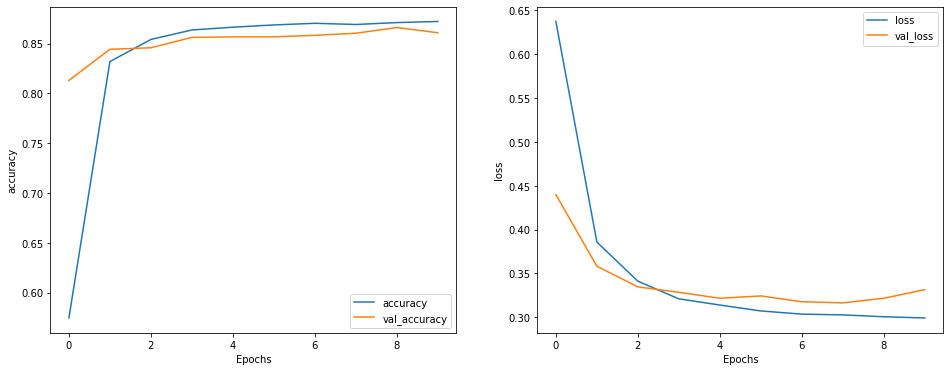

In [20]:
plt.figure(figsize=(16,6))
plt.subplot(1,2,1)
plot_graphs(history, 'accuracy')
plt.subplot(1,2,2)
plot_graphs(history, 'loss')